In [ ]:
#Trade group
#Christina and Arjun

In [ ]:
#Helpful links:
#SOURCE: https://www.census.gov/data/developers/data-sets/international-trade.html
#DOCUMENTATION: https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf
#NAICS ENDPOINT DOCUMENTATION: https://api.census.gov/data/timeseries/intltrade/imports/naics/variables.html

In [ ]:
#Useful dates:
#March 1 = announced
#March 8 = signed
#March 23 = in effect

In [55]:
# Import dependencies
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [25]:
# Census Trade API Key
from config import api_key
from pprint import pprint

In [26]:
# Set-up request
base_url = "https://api.census.gov/data/timeseries/intltrade/imports/naics"
# Interested in steel and aluminum (NAICS==331)
    # Motivation: https://www.usatoday.com/story/news/politics/2018/03/08/trump-planning-make-formal-tariff-announcement/406065002/
    # NAICS info: https://www.bls.gov/iag/tgs/iag331.htm

In [27]:
#SET UP INITIAL PARAMETERS

#CON_CHA_MO = (monthly) 15-digit Imports for Consumption, Charges
#CON_VAL_MO = (monthly) Imports for Insurance and Freight
#CON_CIF_MO = (monthly) 15-digit Aggregate of the above two

#CTY_NAME = 50-character Country Name
#NAICS_LDESC = 150-character NAICS Description
#NAICS_SDESC = 50-character NAICS Description

#CTY_CODE = 4-character Country Code
#https://www.census.gov/foreign-trade/schedules/c/country.txt
#NAICS = 2-, 3-, 4-, or 6-character NAICS code

params = {
    "key": api_key,
    "get" : "CON_CHA_MO,CTY_NAME,CON_CIF_MO,CON_VAL_MO,NAICS_LDESC,NAICS_SDESC",
    "COMM_LVL": "NA3",
    "CTY_CODE": 5700,
    "NAICS" : 331,
}

In [38]:
#Set up a dictionary of results
results = {"year":[],"month":[],"imports":[],"country":[]}

In [39]:
#LOOK TEN YEARS OUT
#Make API calls for the three months we're interested in
years = ["2013","2013","2013","2013","2013","2013","2013","2013","2013","2013","2013","2013",
         "2014","2014","2014","2014","2014","2014","2014","2014","2014","2014","2014","2014",
         "2015","2015","2015","2015","2015","2015","2015","2015","2015","2015","2015","2015",
         "2016","2016","2016","2016","2016","2016","2016","2016","2016","2016","2016","2016",
         "2017","2017","2017","2017","2017","2017","2017","2017","2017","2017","2017","2017",
         "2018","2018"]
months = ["01","02","03","04","05","06","07", "08","09","10","11","12",
          "01","02","03","04","05","06","07", "08","09","10","11","12",
          "01","02","03","04","05","06","07", "08","09","10","11","12",
          "01","02","03","04","05","06","07", "08","09","10","11","12",
          "01","02","03","04","05","06","07", "08","09","10","11","12",
          "01","02"]

for y,m in zip(years,months):
    #Update the month param
    params['YEAR'] = y
    results['year'].append(y)
    params['MONTH'] = m
    results['month'].append(m)
    # Run requests to grab the JSON at the requested URL
    trade_data = requests.get(base_url, params=params)
    #print(trade_data.url)
    trade_data = trade_data.json()
    #pprint(trade_data)
    
    #Note- I am storing the imports for consumption, charges as imports
    results['imports'].append(trade_data[1][0]) 
    results['country'].append(trade_data[1][1])

#Add these in the appropriate loop...
#time = ISO-8601 Date/Time value
#MONTH = 2-character Month 02 03 04
#YEAR = 4-character Year


In [46]:
trade_df = pd.DataFrame(
    {"Exporter": results['country'],
     "Year": results['year'],
     "Month": results['month'],
     "Imports": results['imports'],
    })

In [57]:
x_axis = np.arange(62)
print(x_axis)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


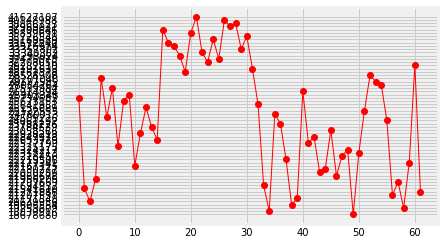

In [58]:
plt.title("")
plt.xlabel("")
plt.ylabel("")

#plt.hlines(0, 0, x_lim, alpha=0.2)
#plt.xlim(0, x_lim)
#plt.ylim(-1.25, 1.25)

plt.plot(x_axis, trade_df['Imports'], marker="o", color="red", linewidth=1)
plt.show()